# Fan-In Binary Tree

Experiment: `/network/tmp1/chenant/ant/sr_trace/2021-01-24/21-54-13`

Today: January 25, 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import files

Read the dfs, filter out the LSF value function agent from the `1228` runs and use the new LSF value function agent from the `1230` runs (which has the elig traces) for comparison.

In [2]:
sfAg_in_path = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-24/21-54-13/small_progress.csv'

pd_df_sep = '\|\|'

In [3]:
# LSF value function agent
sf_ag_raw_df = pd.read_csv(sfAg_in_path, sep=pd_df_sep)

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
"""
def script_get_data_df():
    # ==
    # Filter the elig trace dfs
    curdf = el_ag_raw_df[el_ag_raw_df['agentCls_name'] != 'SFReturnAgent']
    full_df = pd.concat([curdf, sf_ag_raw_df])
    return full_df

Data_df = script_get_data_df()
"""

withDate_Data_df = sf_ag_raw_df.copy(deep=True)
print(len(withDate_Data_df))
withDate_Data_df[0:3]

106200


,"2021-01-24 21:54:13,731",num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,"2021-01-24 21:54:13,782",500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,...,5,-0.045497,0.726980,0.726980,0.0,0.0,0.000414,NaN,NaN,None
1,"2021-01-24 21:54:13,788",500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,...,5,-3.882935,0.727153,0.727153,0.0,0.0,3.015366,NaN,NaN,None
2,"2021-01-24 21:54:13,805",500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,...,5,4.599415,0.726948,0.726948,0.0,0.0,4.238156,NaN,NaN,None


#### Manually drop the date time column

In [5]:
Data_df = withDate_Data_df.copy(deep=True)
del Data_df['2021-01-24 21:54:13,731']
print(list(Data_df))
print(len(Data_df))
Data_df[0:3]

['num_episodes', 'envCls_name', 'env_kwargs', 'agentCls_name', 'seed', 'gamma', 'lr', 'lamb', 'eta_trace', 'use_true_reward_params', 'use_true_sf_params', 'episode_idx', 'total_steps', 'cumulative_reward', 'v_fn_rmse', 'sf_G_rmse', 'sf_matrix_rmse', 'reward_vec_rmse', 'value_loss_avg', 'reward_loss_avg', 'sf_loss_avg', 'et_loss_avg']
106200


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,True,...,5,-0.045497,0.726980,0.726980,0.0,0.0,0.000414,NaN,NaN,None
1,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,True,...,5,-3.882935,0.727153,0.727153,0.0,0.0,3.015366,NaN,NaN,None
2,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,True,...,5,4.599415,0.726948,0.726948,0.0,0.0,4.238156,NaN,NaN,None


## Parameter study: TD(0) and KSF

### Sum across episode
#### NOTE: not totally correct AUC, since we are skipping many of the later episodes
Still gets the same rough estimate though maybe run a more rigorous test later.

In [6]:
def get_RMSE_summed_over_episodes(in_df):
    """
    Helper method, computes sum over all RMSEs (i.e. area under
    the curve) given independent columns
    """
    # 
    df = in_df.copy(deep=True)
    
    # ==
    # Filter for episodes
    df = df[df['episode_idx'] < 1000]
    
    # ==
    # Select for independent columns
    not_indep_cols = ['episode_idx', 'total_steps', 'cumulative_reward', 
                      'v_fn_rmse', 'sf_G_rmse','sf_matrix_rmse',
                      'reward_vec_rmse', 'value_loss_avg', 
                      'reward_loss_avg','sf_loss_avg', 'et_loss_avg']
    indep_cols = [c for c in list(df) if c not in not_indep_cols]
    
    # ==
    sum_df = df.groupby(indep_cols).sum().reset_index()
    
    # ==
    # Sum over selected portions of episode
    return sum_df
    
    
    
EpisSummed_df = get_RMSE_summed_over_episodes(Data_df)
print(len(EpisSummed_df))
EpisSummed_df[0:3]

1800


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg
0,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,False,...,3916,295,48.584897,42.760709,42.760709,0.0,10.073624,45.592893,1.468371,0.0
1,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,False,...,3916,295,48.584897,42.760709,42.760709,0.0,10.073624,45.592893,1.468371,0.0
2,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,True,...,3916,295,48.584897,42.760709,42.760709,0.0,0.000000,45.592893,0.000000,0.0


#### Average over episodes

In [7]:
def get_RMSE_epis_averaged(in_df, episode_num=100, average_window=100):
    """
    Helper method
    """
    # 
    df = in_df.copy(deep=True)
    
    # ==
    # Filter for episodes
    range_left = episode_num - average_window
    df = df[df['episode_idx'] >= range_left]
    df = df[df['episode_idx'] < episode_num]
    
    # ==
    # Select for independent columns
    not_indep_cols = ['episode_idx', 'total_steps', 'cumulative_reward', 
                      'v_fn_rmse', 'sf_G_rmse','sf_matrix_rmse',
                      'reward_vec_rmse', 'value_loss_avg', 
                      'reward_loss_avg','sf_loss_avg', 'et_loss_avg']
    indep_cols = [c for c in list(df) if c not in not_indep_cols]
    
    # ==
    avg_df = df.groupby(indep_cols).mean().reset_index()
    avg_df['episode_idx'] = [(episode_num-1)] * len(avg_df)
    return avg_df

episAvg_df = get_RMSE_epis_averaged(Data_df, 100, 100)    
print(len(episAvg_df))
episAvg_df[0:2]

1800


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg
0,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,False,...,99,5.0,0.72717,0.726123,0.726123,0.0,0.176152,0.779751,0.025151,0.0
1,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.001,0.0,0.0,False,...,99,5.0,0.72717,0.726123,0.726123,0.0,0.176152,0.779751,0.025151,NaN


### Plot parameter study

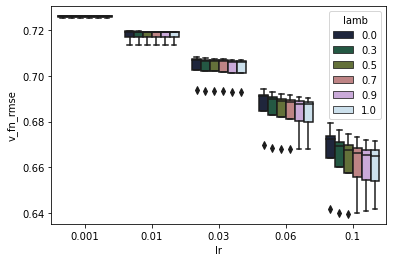

In [8]:
def lr_rmse_boxplot(data, x='lr', y='v_fn_rmse', hue='lamb', filters=None):
    # ==
    # Filters
    if filters is None:
        filters = {
            'agentCls_name': 'SFReturnAgent',
            'eta_trace': 0.0,
            'env_kwargs': "{'depth': 5, 'terminal_reward_stdev': 2.0}",
            'use_true_sf_params': False,
            'use_true_reward_params': False,
        }
    
    df = data.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    # round
    df[hue] = [round(e, 3) for e in df[hue]]
    # hues
    n_hues = len(set(df[hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.boxplot(x=x, y=y, hue=hue,
                 palette=c_palette, 
                 data=df)
    
lr_rmse_boxplot(episAvg_df)

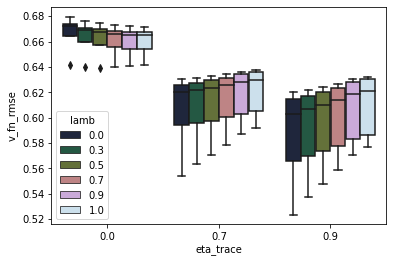

In [9]:
lr_rmse_boxplot(episAvg_df, x='eta_trace', filters={
    'agentCls_name': 'SFReturnAgent',
    'lr': 0.1,
    'env_kwargs': "{'depth': 5, 'terminal_reward_stdev': 2.0}",
    'use_true_sf_params': False,
    'use_true_reward_params': False,
})

Pausing, not sure if this is demonstrating a enviornment where the KSF is working better

### More plots

In [10]:
def get_averaged_best_rmse_param_df(in_df, filters=None):
    dep_col = 'v_fn_rmse'
    indep_cols = ['agentCls_name', 'lamb', 'eta_trace', 
                  'use_true_sf_params', 'use_true_reward_params']
    search_cols = ['lr']
    
    # NOTE: no `lr` b.c. we want to find the best
    epis_to_plot = [500]
    avg_window_len = 500
    
    
    # ==
    # Search for best parameters 
    df = in_df.copy(deep=True)
    df_list = []
    
    for i, cur_epis_num in enumerate(epis_to_plot):
        cur_avg_df = get_RMSE_epis_averaged(df, episode_num=cur_epis_num, 
                                            average_window=avg_window_len)
        cur_idx = (cur_avg_df.groupby(indep_cols)[dep_col].transform(min) 
                   == cur_avg_df[dep_col])
        
        
        cur_filter_df = cur_avg_df[cur_idx].reset_index()
        idxs = (pd.merge(cur_avg_df, cur_filter_df, 
                         on=(indep_cols + search_cols), how='left', 
                         indicator=True)['_merge'] 
                == 'both')
        
        df_list.append(cur_avg_df[idxs])
    
    best_df = pd.concat(df_list, ignore_index=True)
    
    return best_df
    

avg_best_param_df = get_averaged_best_rmse_param_df(Data_df)
print(len(avg_best_param_df))
avg_best_param_df[0:2]

360


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg
0,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.1,0.0,0.0,False,...,499,5.0,0.823473,0.617628,0.617628,0.0,0.070389,0.751264,0.023258,0.0
1,500,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 2.0}",SFReturnAgent,2,0.9,0.1,0.0,0.0,False,...,499,5.0,0.823473,0.617628,0.617628,0.0,0.070389,0.751264,0.023258,NaN


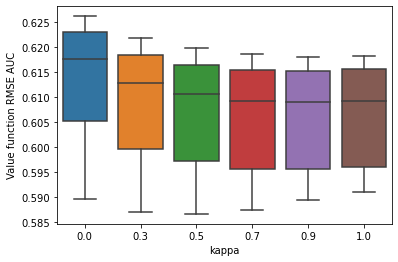

In [11]:
def script_plt_best_param_x_lamb_boxplot(best_df):
    # ==
    plt_x = 'lamb'
    plt_y = 'v_fn_rmse'
    
    filters = {
        'agentCls_name': 'SFReturnAgent',
        'eta_trace': 0.0,
        'use_true_sf_params': False,
        'use_true_reward_params': False,
    }
    
    df = best_df.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    sns.boxplot(x=plt_x, y=plt_y, 
                 data=df)
    plt.ylabel('Value function RMSE AUC')
    plt.xlabel('kappa')
    
    
script_plt_best_param_x_lamb_boxplot(avg_best_param_df)

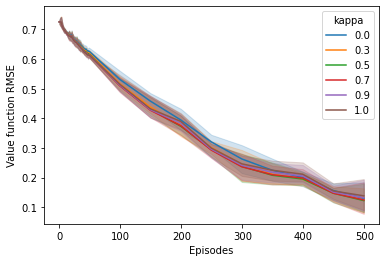

In [13]:
def script_helper_get_best_param_for_episode(best_df, episode_idx):
    indep_cols = ['agentCls_name', 'lamb', 'eta_trace', 
                  'use_true_sf_params', 'use_true_reward_params', 'lr']
    
    df = best_df.copy(deep=True)
    df = df[df['episode_idx'] == episode_idx]
    
    return df.groupby(indep_cols).mean()
    
    
def script_plt_learning_over_epis(in_data_df, in_best_df, filters=None):
    indep_cols = ['agentCls_name', 'lamb', 'eta_trace', 'lr',
                  'use_true_sf_params', 'use_true_reward_params']
    
    
    df = in_data_df.copy(deep=True)
    best_df = in_best_df.copy(deep=True)
    
    # Filter df
    if filters is None:
        filters = {
            'agentCls_name': 'SFReturnAgent',
            'eta_trace': 0.0,
            'use_true_sf_params': False,
            'use_true_reward_params': False,
        }
    for k in filters:
        df = df[df[k] == filters[k]]
    df = df.reset_index()
    
    # Filter the oriingla full df with just the best params
    best_param_df = script_helper_get_best_param_for_episode(best_df, episode_idx=499)
    idxs = (pd.merge(df, best_param_df, 
                         on=indep_cols, how='left', 
                         indicator=True)['_merge'] 
                == 'both')
    df = df[idxs]
    
    plt_hue = 'lamb'
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    # hues
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("tab10", n_hues) 
    
    # ==
    # Plot
    sns.lineplot(x='episode_idx', y='v_fn_rmse', hue=plt_hue, 
                 ci=95, n_boot=200,
                 palette=c_palette,
                 data=df)
    #plt.ylim([0,8.5])
    #plt.xlim([-10,500])
    plt.xlabel('Episodes')
    plt.ylabel('Value function RMSE')
    plt.legend(title='kappa')
    
script_plt_learning_over_epis(Data_df, avg_best_param_df)

# NOTE: below deprecated. Reference only.

## Compare: TD(0) with LSF
### Parameter study

In [58]:
def script_helper_true_param_filter(in_df, filters):
    """Helper for filtering the different true param settings"""
    df = in_df.copy(deep=True)
    df = df[df['use_true_sf_params'] == filters[0]]
    df = df[df['use_true_reward_params'] == filters[1]]
    return df

def script_plot_v_fn_rmse_td0_epis(df, n_episode_idx=9,
                                   xscale='linear', yscale='linear'):
    plt_x = 'lr'
    plt_y = 'v_fn_rmse'
    plt_hue = 'lamb'
    plt_ci = None
    plt_n_boot = 100
    
    # Filter
    df = script_helper_true_param_filter(df, [False, False])
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['eta_trace'] == 0.0]  # no elig trace
    df = df[df['env_kwargs'] == "{'depth': 7}"]
    
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    
    df = df[df['episode_idx']==n_episode_idx]
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=df)
    
    #plt.yscale([])
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')

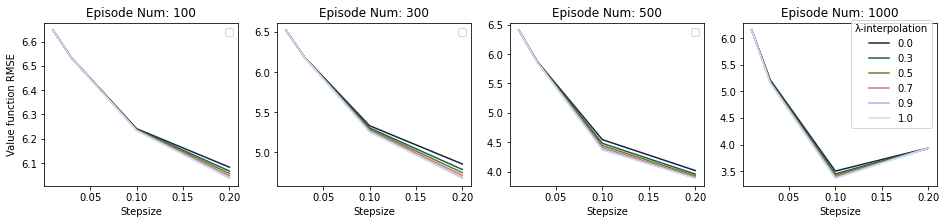

In [59]:
def script_plot_multi_v_fn_rmse_td0_epis(df, episode_idx_list):
    
    for i, epis_idx in enumerate(episode_idx_list):
        plt.subplot(1, len(episode_idx_list), (i+1))
        script_plot_v_fn_rmse_td0_epis(df, epis_idx)
        
        plt.title(f'Episode Num: {epis_idx+1}')
        plt.xlabel('Stepsize')
        # Y axis
        if i == 0:
            plt.ylabel('Value function RMSE')
        else:
            plt.ylabel('')
        
        # Legend
        if i < (len(episode_idx_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(title='λ-interpolation', bbox_to_anchor=(1, 1.05), )
    
    pass

plt.figure(figsize=(16,3))
script_plot_multi_v_fn_rmse_td0_epis(Data_df, 
                                     episode_idx_list=[99, 299, 499, 999])

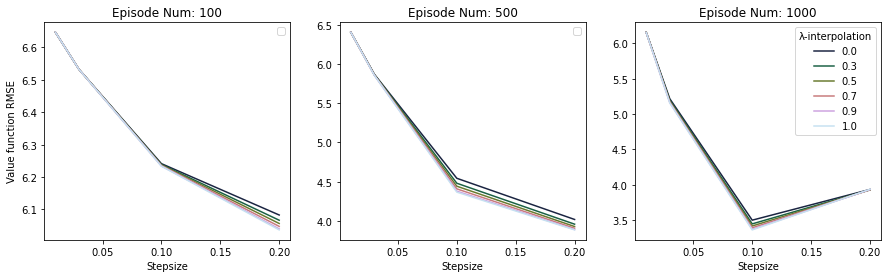

In [64]:
# Better plot
plt.figure(figsize=(15,4))
script_plot_multi_v_fn_rmse_td0_epis(Data_df, 
                                     episode_idx_list=[99, 499, 999])
plt.legend(loc='upper right', title='λ-interpolation')

### Convergence over episodes

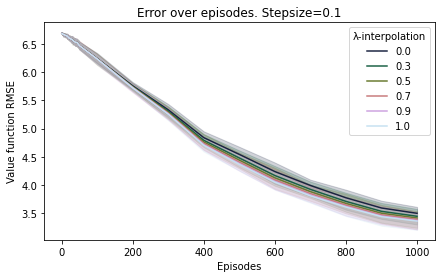

In [21]:
def script_plot_rmse_over_episodes(df, y='v_fn_rmse', hue='lamb'):
    plt_x = 'episode_idx'
    plt_y = y
    plt_hue = hue
    cur_lr = 0.1
    plt_ci = 95
    plt_n_boot = 200
    
    # Filter
    df = script_helper_true_param_filter(df, [False, False])
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['eta_trace'] == 0.0]  # no elig trace
    df = df[df['lr'] == cur_lr]  # no elig trace
    df = df[df['env_kwargs'] == "{'depth': 7}"]
    
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=df)
    
    plt.title(f'Error over episodes. Stepsize={cur_lr}')
    plt.ylabel('Value function RMSE')
    plt.xlabel('Episodes')
    plt.legend(title='λ-interpolation')

plt.figure(figsize=(7,4))
script_plot_rmse_over_episodes(Data_df, y='v_fn_rmse', hue='lamb')

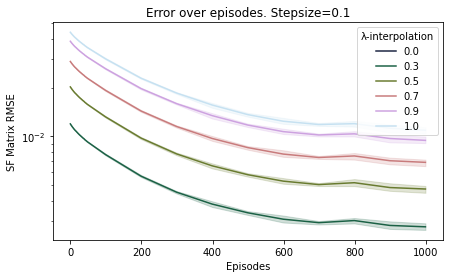

In [22]:
plt.figure(figsize=(7,4))
script_plot_rmse_over_episodes(Data_df, y='sf_matrix_rmse', hue='lamb')
plt.ylabel('SF Matrix RMSE')
plt.yscale('log')

## Comparison: LSF with TD(lambda)

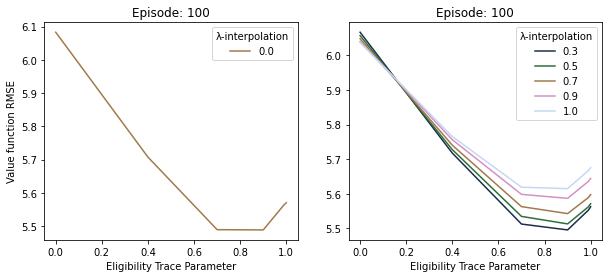

In [77]:
def script_plot_trace_best_stepsize(df, episode_idx=9, true_param_filter=[False,False], ylim=None):
    plt_x = 'eta_trace'
    plt_y = 'v_fn_rmse'
    plt_hue = 'lamb'
    plt_ci = None
    plt_n_boot = 200
    
    # ==
    # Filter
    df = script_helper_true_param_filter(df, true_param_filter)
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['episode_idx'] == episode_idx]
    df = df[df['env_kwargs'] == "{'depth': 7}"]
    
    # Filter for TD(lambda)
    tdlamb_df = df[df['lamb'] == 0.0] 
    # Filter for LSF
    lsf_df = df[df['lamb'] > 0.0]
    
    # ==
    # Find best lr parameters
    def best_lr_df(cur_df):
        cur_df = cur_df.groupby(['lamb', 'eta_trace', 'lr']).mean()
        cur_df_mask = cur_df.groupby(['lamb','eta_trace'])['v_fn_rmse'].transform(min) == cur_df['v_fn_rmse']
        cur_df = cur_df[cur_df_mask]
        return cur_df.reset_index()
    
    best_lr_df_dict = {}
    best_lr_df_dict['td_lambda'] = best_lr_df(tdlamb_df)
    best_lr_df_dict['lsf'] = best_lr_df(lsf_df)
    
    # ==
    # Plot
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    n_hues = len(set(best_lr_df_dict['td_lambda'][plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=best_lr_df_dict['td_lambda'])
    plt.ylim(ylim)
    plt.title(f'Episode: {episode_idx+1}')
    plt.ylabel('Value function RMSE')
    plt.xlabel('Eligibility Trace Parameter')
    plt.legend(title='λ-interpolation')
    
    
    plt.subplot(1,2,2)
    n_hues = len(set(best_lr_df_dict['lsf'][plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=best_lr_df_dict['lsf'])
    plt.ylim(ylim)
    plt.title(f'Episode: {episode_idx+1}')
    plt.ylabel('')
    plt.xlabel('Eligibility Trace Parameter')
    plt.legend(title='λ-interpolation')
    
    
    return best_lr_df_dict
    

cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=99, 
                                               true_param_filter=[False,False], 
                                               ylim=None)

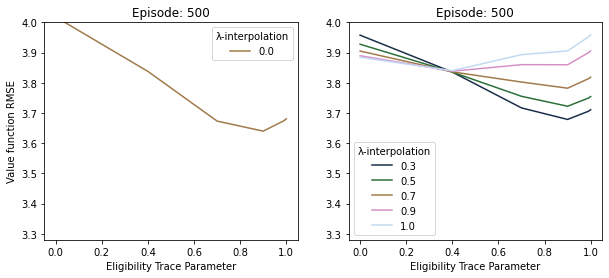

In [78]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, 
                                               true_param_filter=[False,False], 
                                               ylim=[3.28, 4.0])

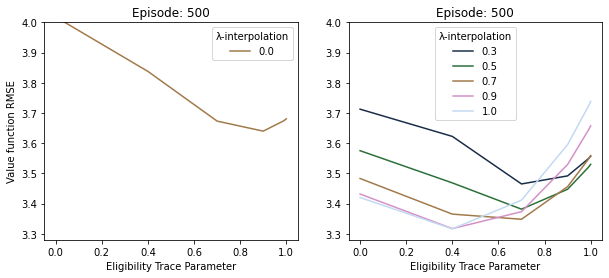

In [79]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, 
                                               true_param_filter=[False,True], 
                                               ylim=[3.28, 4.0])

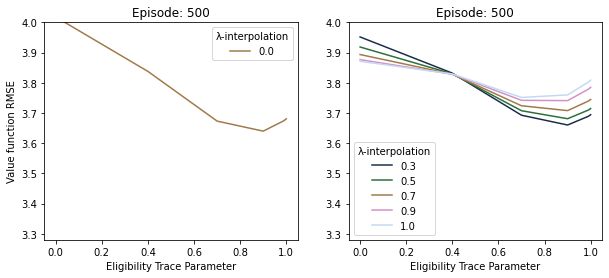

In [80]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, 
                                               true_param_filter=[True,False], 
                                               ylim=[3.28, 4.0])

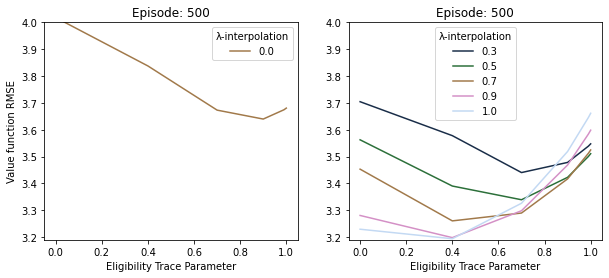

In [81]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, 
                                               true_param_filter=[True,True], 
                                               ylim=[3.19, 4.0])

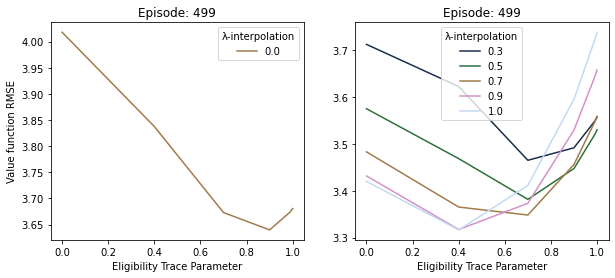

In [42]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, ylim=None)

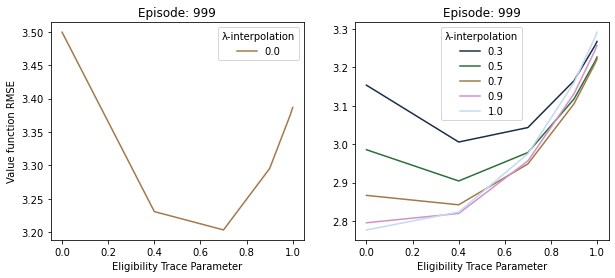

In [43]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=999, ylim=None)

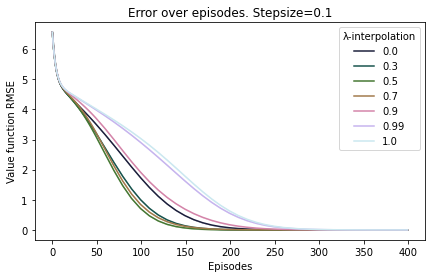

In [18]:
def script_plot_rmse_fixed_lr_trace_over_episodes(df, y='v_fn_rmse', hue='lamb'):
    plt_x = 'episode_idx'
    plt_y = y
    plt_hue = hue
    cur_lr = 0.1
    plt_ci = 95
    plt_n_boot = 200
    
    # Filter
    df = script_helper_true_param_filter(df, [False, False])
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['eta_trace'] == 0.4]  # no elig trace
    df = df[df['lr'] == cur_lr]  # no elig trace
    
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=df)
    
    plt.title(f'Error over episodes. Stepsize={cur_lr}')
    plt.ylabel('Value function RMSE')
    plt.xlabel('Episodes')
    plt.legend(title='λ-interpolation')

plt.figure(figsize=(7,4))
script_plot_rmse_fixed_lr_trace_over_episodes(Data_df, y='v_fn_rmse', hue='lamb')